In [6]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [10]:
dataset = []
for folder in ["./Dataset/Dataset A**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()
#?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037 entries, 622 to 860
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1037 non-null   object 
 1   label     1037 non-null   object 
 2   offset    1037 non-null   float64
dtypes: float64(1), object(2)
memory usage: 32.4+ KB


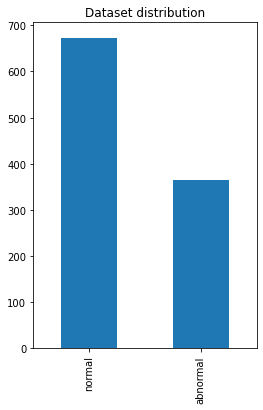

In [11]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [4]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 829
Test: 208


## Visualising the data and features

./set_b\normal_noisynormal_130_1306347376079_C.wav
./set_b\extrastole__128_1306344005749_A.wav


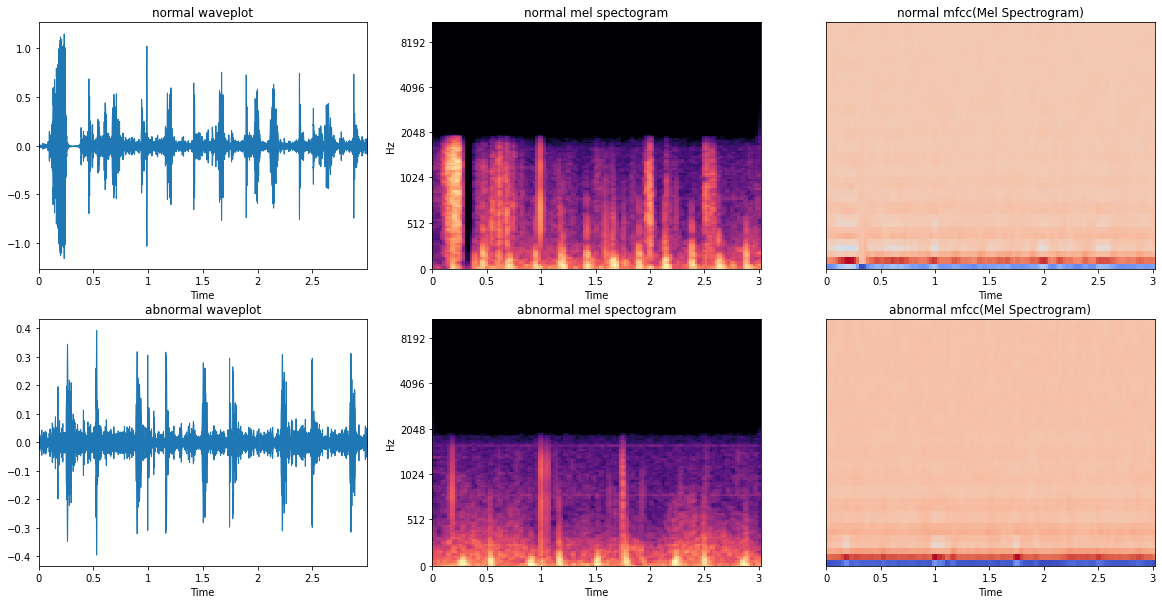

In [18]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
    
#     #chroma
#     idx+=1
#     plt.subplot(2,3,idx)
#     chroma = librosa.filters.chroma(sr=sr,n_fft = 2048, n_chroma=12,  ctroct=5.0, octwidth=2, norm=2, base_c=True)
#     librosa.display.specshow(chroma, x_axis='time')
#     plt.title("%s chroma" % label)
    
plt.show()

#

./set_b\normal_noisynormal_130_1306347376079_C.wav
./set_b\extrastole__128_1306344005749_A.wav


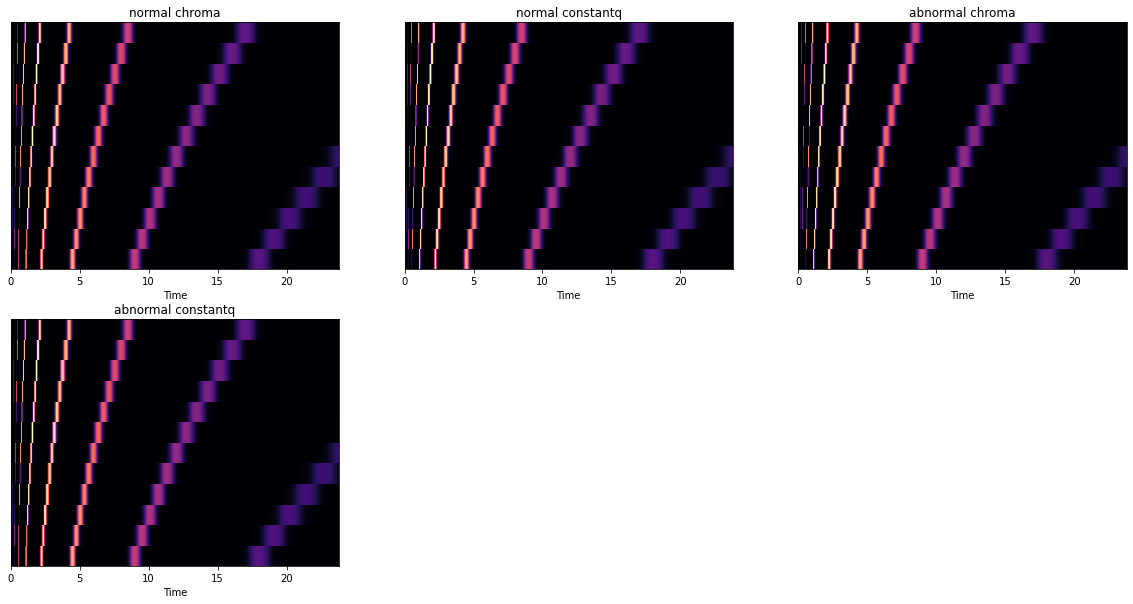

In [26]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    #chroma
    idx+=1
    plt.subplot(2,3,idx)
    chroma = librosa.filters.chroma(sr=sr,n_fft = 2048, n_chroma=12,  ctroct=5.0, octwidth=2, norm=2, base_c=True)
    librosa.display.specshow(chroma, x_axis='time')
    plt.title("%s chroma" % label)
    
    #constant Q
    idx+=1
    plt.subplot(2,3,idx)
    constantq = librosa.filters.constant_q(sr=sr, fmin=None, n_bins=84, bins_per_octave=12, filter_scale=1, pad_fft=True, norm=1)
    librosa.display.specshow(chroma, x_axis='time')
    plt.title("%s constantq" % label)
    
plt.show()

#

./set_b\normal_noisynormal_130_1306347376079_C.wav
./set_b\extrastole__128_1306344005749_A.wav


<Figure size 1440x720 with 0 Axes>

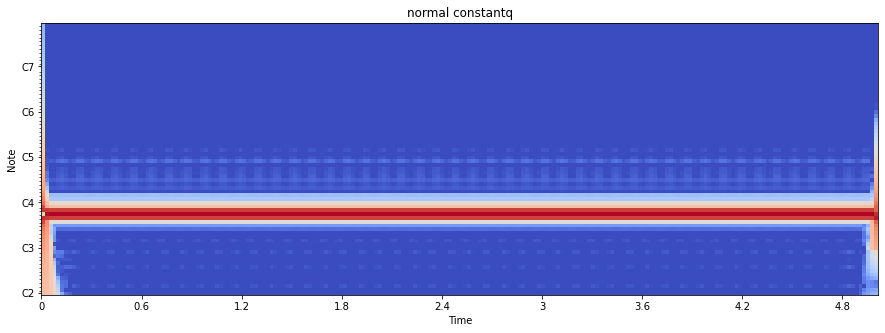

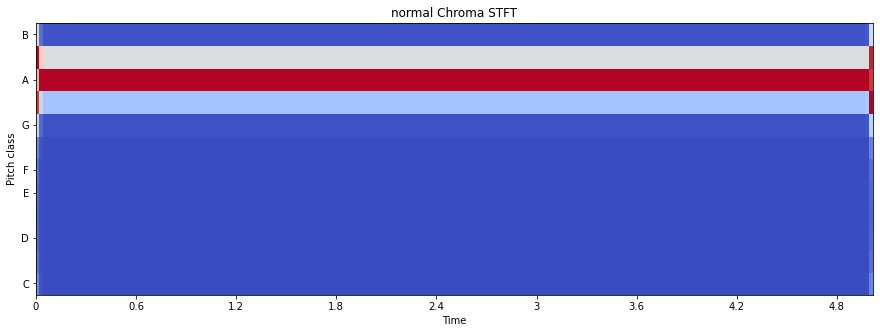

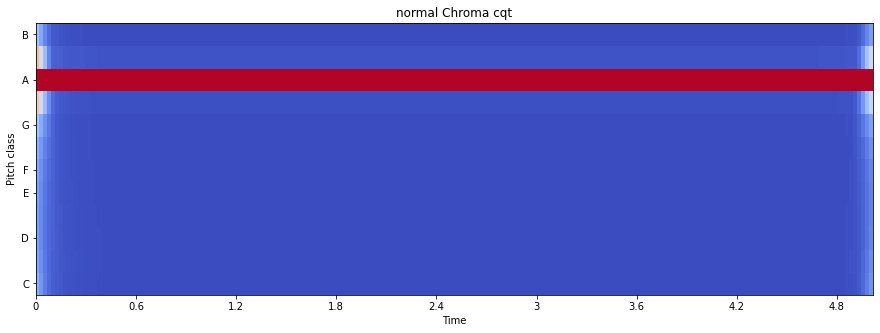

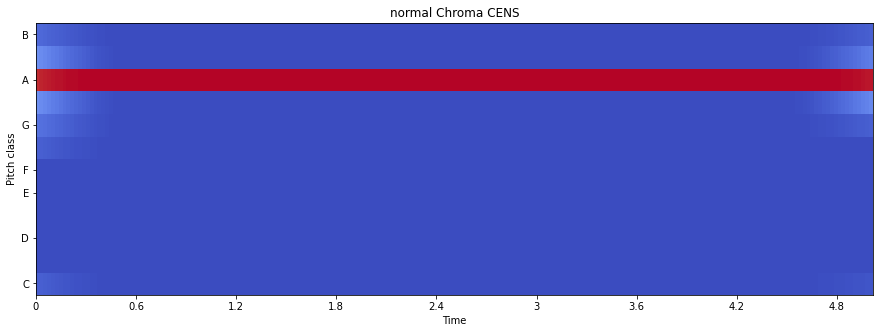

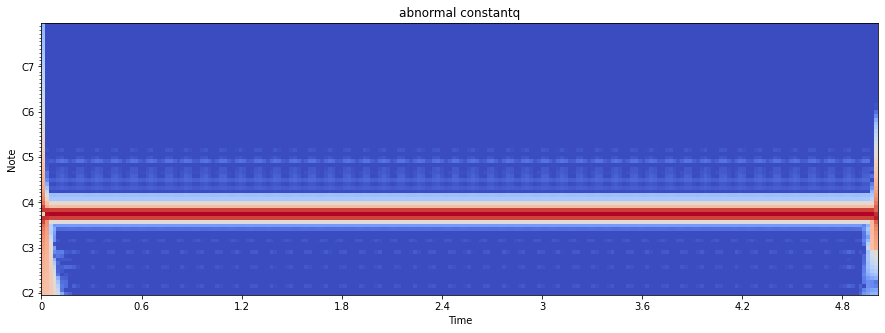

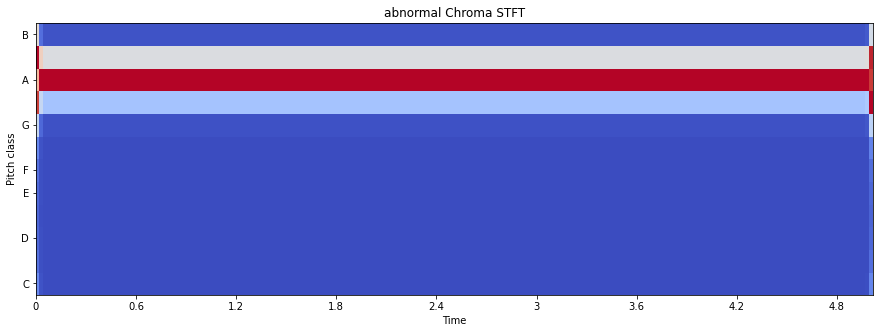

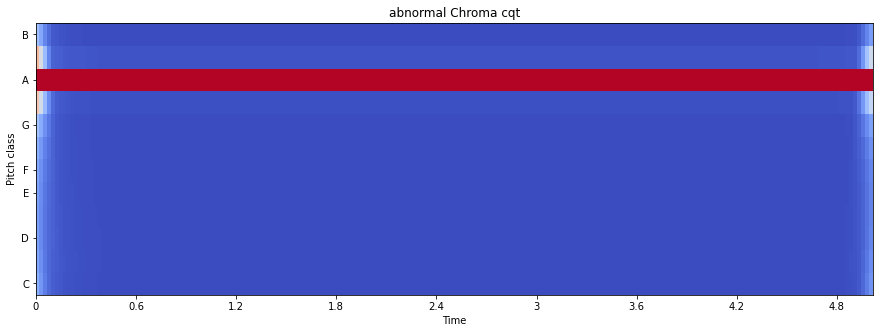

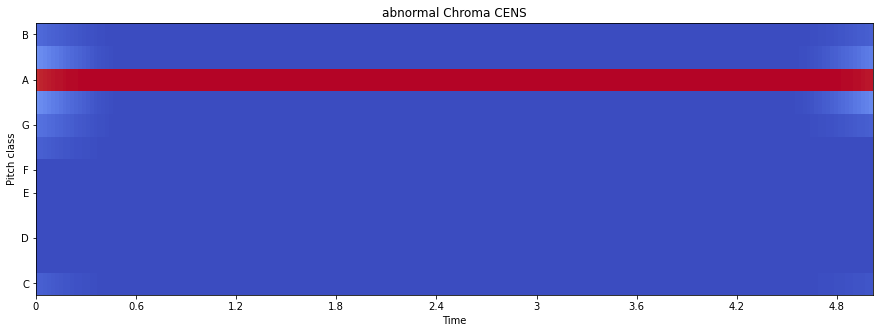

In [35]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    ipd.Audio(y, rate=sr)
    
    fmin = librosa.midi_to_hz(36)
    hop_length = 512
    C = librosa.cqt(x, sr=sr, fmin=fmin, n_bins=72, hop_length=hop_length)
    
    #constant Q time
    
    logC = librosa.amplitude_to_db(numpy.abs(C))
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
    plt.title("%s constantq" % label)
    
    #Chroma STFT
    chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title("%s Chroma STFT" % label)
    
    #Chroma cqt
    chromagram = librosa.feature.chroma_cqt(x, sr=sr, hop_length=hop_length)
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title("%s Chroma cqt" % label)
    
    #Chroma CENS
    chromagram = librosa.feature.chroma_cens(x, sr=sr, hop_length=hop_length)
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title("%s Chroma CENS" % label)
    
plt.show()


## Extracting features

In [36]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [37]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [00:20<00:00, 10.35it/s]

X train: (829, 40, 130)
X test: (208, 40, 130)


In [38]:
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)
#nomal=0, abnormal=1
#print(y_train)
# Compute class weights
class_test = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
#print(type(class_test))
class_weights = {0:class_test[0],1:class_test[1]}

In [39]:
print(np.unique(y_train))


[0 1]


## Input Shapes

In [40]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (829, 40, 130, 1)
Y train: (829, 2)
X test: (208, 40, 130, 1)
Y test: (208, 2)


## Building Model

In [41]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 31, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 30, 64)         8

## Compiling Model

In [42]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Fitting Model

In [43]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)

Epoch 1/300
7/7 [==============================] - 4s 528ms/step - loss: 8.3119 - accuracy: 0.4475 - val_loss: 1.4227 - val_accuracy: 0.6346
Epoch 2/300
7/7 [==============================] - 3s 445ms/step - loss: 3.1790 - accuracy: 0.5657 - val_loss: 1.2881 - val_accuracy: 0.3654
Epoch 3/300
7/7 [==============================] - 3s 457ms/step - loss: 2.0413 - accuracy: 0.4487 - val_loss: 0.6339 - val_accuracy: 0.6731
Epoch 4/300
7/7 [==============================] - 3s 408ms/step - loss: 1.3419 - accuracy: 0.5730 - val_loss: 0.8205 - val_accuracy: 0.4038
Epoch 5/300
7/7 [==============================] - 3s 397ms/step - loss: 1.1127 - accuracy: 0.4777 - val_loss: 0.6597 - val_accuracy: 0.5385
Epoch 6/300
7/7 [==============================] - 3s 378ms/step - loss: 0.9756 - accuracy: 0.5802 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 7/300
7/7 [==============================] - 3s 370ms/step - loss: 0.8539 - accuracy: 0.5320 - val_loss: 0.7195 - val_accuracy: 0.4904
Epoch 8/300
7

Epoch 59/300
7/7 [==============================] - 3s 445ms/step - loss: 0.5387 - accuracy: 0.7214 - val_loss: 0.5420 - val_accuracy: 0.7981
Epoch 60/300
7/7 [==============================] - 3s 494ms/step - loss: 0.5411 - accuracy: 0.7201 - val_loss: 0.5345 - val_accuracy: 0.7981
Epoch 61/300
7/7 [==============================] - 4s 506ms/step - loss: 0.5321 - accuracy: 0.7069 - val_loss: 0.5228 - val_accuracy: 0.7692
Epoch 62/300
7/7 [==============================] - 3s 498ms/step - loss: 0.5655 - accuracy: 0.7177 - val_loss: 0.5390 - val_accuracy: 0.7740
Epoch 63/300
7/7 [==============================] - 3s 423ms/step - loss: 0.5526 - accuracy: 0.6671 - val_loss: 0.5423 - val_accuracy: 0.7500
Epoch 64/300
7/7 [==============================] - 3s 448ms/step - loss: 0.5415 - accuracy: 0.7358 - val_loss: 0.5514 - val_accuracy: 0.7596
Epoch 65/300
7/7 [==============================] - 3s 442ms/step - loss: 0.5493 - accuracy: 0.6719 - val_loss: 0.5391 - val_accuracy: 0.7692
Epoch 

Epoch 116/300
7/7 [==============================] - 3s 434ms/step - loss: 0.4536 - accuracy: 0.7624 - val_loss: 0.4502 - val_accuracy: 0.7885
Epoch 117/300
7/7 [==============================] - 3s 418ms/step - loss: 0.4617 - accuracy: 0.7600 - val_loss: 0.4527 - val_accuracy: 0.8173
Epoch 118/300
7/7 [==============================] - 2s 290ms/step - loss: 0.4405 - accuracy: 0.7889 - val_loss: 0.4363 - val_accuracy: 0.8221
Epoch 119/300
7/7 [==============================] - 2s 287ms/step - loss: 0.4434 - accuracy: 0.7696 - val_loss: 0.4292 - val_accuracy: 0.7885
Epoch 120/300
7/7 [==============================] - 2s 271ms/step - loss: 0.4563 - accuracy: 0.7563 - val_loss: 0.4333 - val_accuracy: 0.8077
Epoch 121/300
7/7 [==============================] - 2s 299ms/step - loss: 0.4367 - accuracy: 0.7805 - val_loss: 0.4192 - val_accuracy: 0.8173
Epoch 122/300
7/7 [==============================] - 2s 273ms/step - loss: 0.4626 - accuracy: 0.7503 - val_loss: 0.4196 - val_accuracy: 0.8173

7/7 [==============================] - 2s 349ms/step - loss: 0.2980 - accuracy: 0.8625 - val_loss: 0.2915 - val_accuracy: 0.8606
Epoch 231/300
7/7 [==============================] - 2s 352ms/step - loss: 0.2765 - accuracy: 0.8806 - val_loss: 0.2986 - val_accuracy: 0.8510
Epoch 232/300
7/7 [==============================] - 2s 348ms/step - loss: 0.2711 - accuracy: 0.8926 - val_loss: 0.2840 - val_accuracy: 0.8702
Epoch 233/300
7/7 [==============================] - 3s 369ms/step - loss: 0.2820 - accuracy: 0.8866 - val_loss: 0.2842 - val_accuracy: 0.8606
Epoch 234/300
7/7 [==============================] - 3s 420ms/step - loss: 0.2872 - accuracy: 0.8745 - val_loss: 0.2924 - val_accuracy: 0.8702
Epoch 235/300
7/7 [==============================] - 3s 392ms/step - loss: 0.3064 - accuracy: 0.8758 - val_loss: 0.3207 - val_accuracy: 0.8558
Epoch 236/300
7/7 [==============================] - 3s 416ms/step - loss: 0.2852 - accuracy: 0.8745 - val_loss: 0.2952 - val_accuracy: 0.8702
Epoch 237/300

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

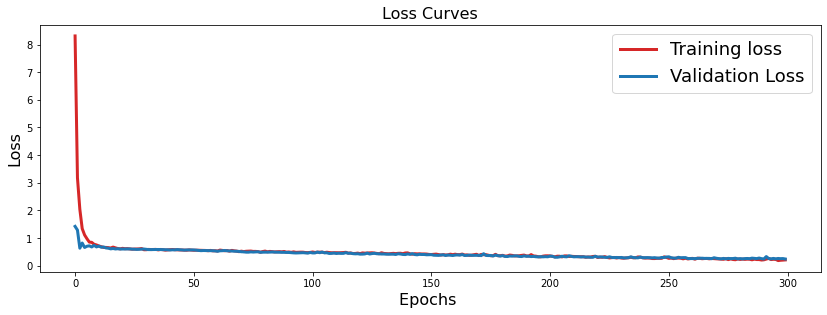

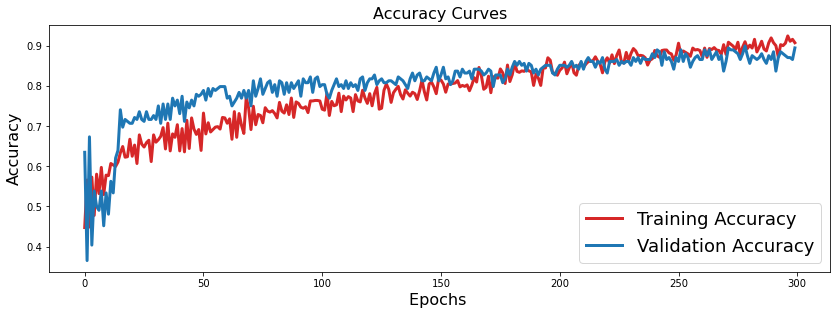

In [44]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [45]:
print(x_test.shape)
print(y_train.shape)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

(208, 40, 130, 1)
(829, 2)
7/7 [==============================] - 0s 59ms/step - loss: 0.2436 - accuracy: 0.8942
Test loss: 0.24356499314308167
Test accuracy: 0.8942307829856873


In [48]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))
print(confusion_matrix(y_pred, y_true))

7/7 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

    abnormal       0.82      0.89      0.85        70
      normal       0.94      0.90      0.92       138

    accuracy                           0.89       208
   macro avg       0.88      0.89      0.88       208
weighted avg       0.90      0.89      0.90       208

[[ 62   8]
 [ 14 124]]


In [56]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(roc_auc)

{0: 0.9622208931419458, 1: 0.9622208931419458, 'micro': 0.9652366863905324}


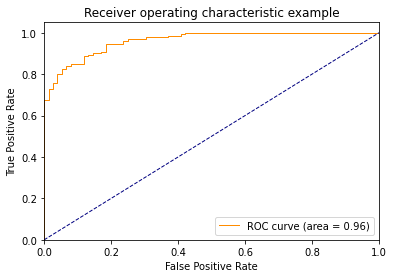

In [55]:
plt.figure()
lw = 1
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Save Model and Weights

In [17]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)

In [18]:
# 1 sec overlap
# Trained for 3sec for files >3sec

### Classifying an heart beat

In [19]:
# load and evaluate a saved model
from keras.models import load_model
 
# load model
model = load_model("heartbeat_classifier.h5")

# File to be classified
classify_file = "c0001.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

1/1 [==============================] - 0s 6ms/step
[[0.9979917  0.00200832]]


In [21]:
pred_class = model.predict_classes(x_test)
if pred_class[0]:
    print("Normal heartbeat")
    print("confidence:",pred[0][1])
else:
    print("Abnormal heartbeat")
    print("confidence:",pred[0][0])

Abnormal heartbeat
confidence: 0.9979917
